# Regression mixture model. 

Mixture modeling has become quite popular and e.g. a Gaussian Mixture Model (GMM) is quite easy to fit using any machine learning package. However, I have seen a few examples where a clustering algorithm that could account for the underlying physical (mechanistic) process would have been interesting to have. 

Imagine that you have a data set that has been generated by $N$ physical components. The functional form of the data-generating process for each component is known e.g. $y = b_0 + b_1 x$. The number of components and the model parameters for each component are however unknown. The task is now to assign each data point to a component and based on this assignment to infer the model parameters for each component. The topic is described in chapter XX of XX which I will refer to as XXX. Using a Gaussian mixture model this can be accomplished e.g. in Scikit Learn using `BayesianGaussianMixture`, but at the time of writing I cannot find other mixture model than the Gaussian.

In this note I will try to cluster some data, but instead of assuming that the underlying components produce data that is Gaussian I will assume the each component produce data according to $y = b_0 + b_1 x$. I have chosen a linear model to keep things simple, but still illustrative. To make things more challenging I have chosen that the clusters (lines) cross, which would cause problems for clustering methods the were not *aware* of (constrained to) the underlying mechanistic model.

The note is structured as follows. First I will analyze the (synthetic) data as if the the classes were known a-priori. The purpose of this part is to become more familiar with `pymc3` and the plots generated by `arviz` as well as compare the Bayesian inference with the results from standard curve fits. Then I proceed to do a simultaneous Bayesian clustering and parameter inference using `pymc3`. The results are analyzed and compared with the true models.

## Some boilerplate code

We start by importing all required packages.

In [ ]:
from typing import Optional
import pickle
import itertools

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3.distributions.transforms as tr
import seaborn as sns
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from pathlib import Path

import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import theano.tensor as tt
import arviz as az
import statsmodels.api as sm

from two_models import plot_parameters

%load_ext watermark

and setting some variables

In [ ]:
THIS_PATH = Path.cwd()
TMP_PATH = THIS_PATH.joinpath("tmp")
TMP_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH = THIS_PATH.joinpath("results")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
NORMAL_FONTSIZE = 20
RANDOM_SEED = 17
CMAP_NAME = "tab10"

np.random.seed(123)

## Make synthetic data

The function below generate linear data with noise for two components.

In [86]:
def model(x, b0, b1):
    # two-parameter model.
    return b1 * x + b0

def make_data():

    # Intercept
    b0 = 0

    # Slopes
    b1 = [-5, 5]

    # Noise
    sigma = 2

    # Sizes
    size1 = 25
    size2 = 35
    
    size = size1 + size2

    print("Total number of data points", size1 + size2)
    print(f"Weight cmp1: {size1 / size:.2f}" )
    print(f"Weight cmp2: {size2 / size:.2f}")

    # Predictor variable
    X1_1 = np.linspace(-2, 2, size1)
    # Simulate outcome variable--cluster 1
    Y1 = model(X1_1, b0, b1[0]) + np.random.normal(loc=0, scale=sigma, size=size1)

    # Predictor variable
    X1_2 = np.linspace(-3, 3, size2)
    # Simulate outcome variable --cluster 2
    Y2 = model(X1_2, b0, b1[1]) + np.random.normal(loc=0, scale=sigma, size=size2)

    return b0, b1, sigma, X1_1, X1_2, Y1, Y2


First I create data for the two components and make a joint data set with anonymous classes. The weights are the fraction of the data points generates by the two components.

In [87]:
b0, b1, sigma, x1, x2, y1, y2 = make_data()

# joint data set with anonymous classes
x = np.append(x1, x2)
y = np.append(y1, y2)

Total number of data points 60
Weight cmp1: 0.42
Weight cmp2: 0.58


Below I show the data, the true models and the true clusters. This plot is actually is the solution I am looking for using clustering with a linear mixture model.

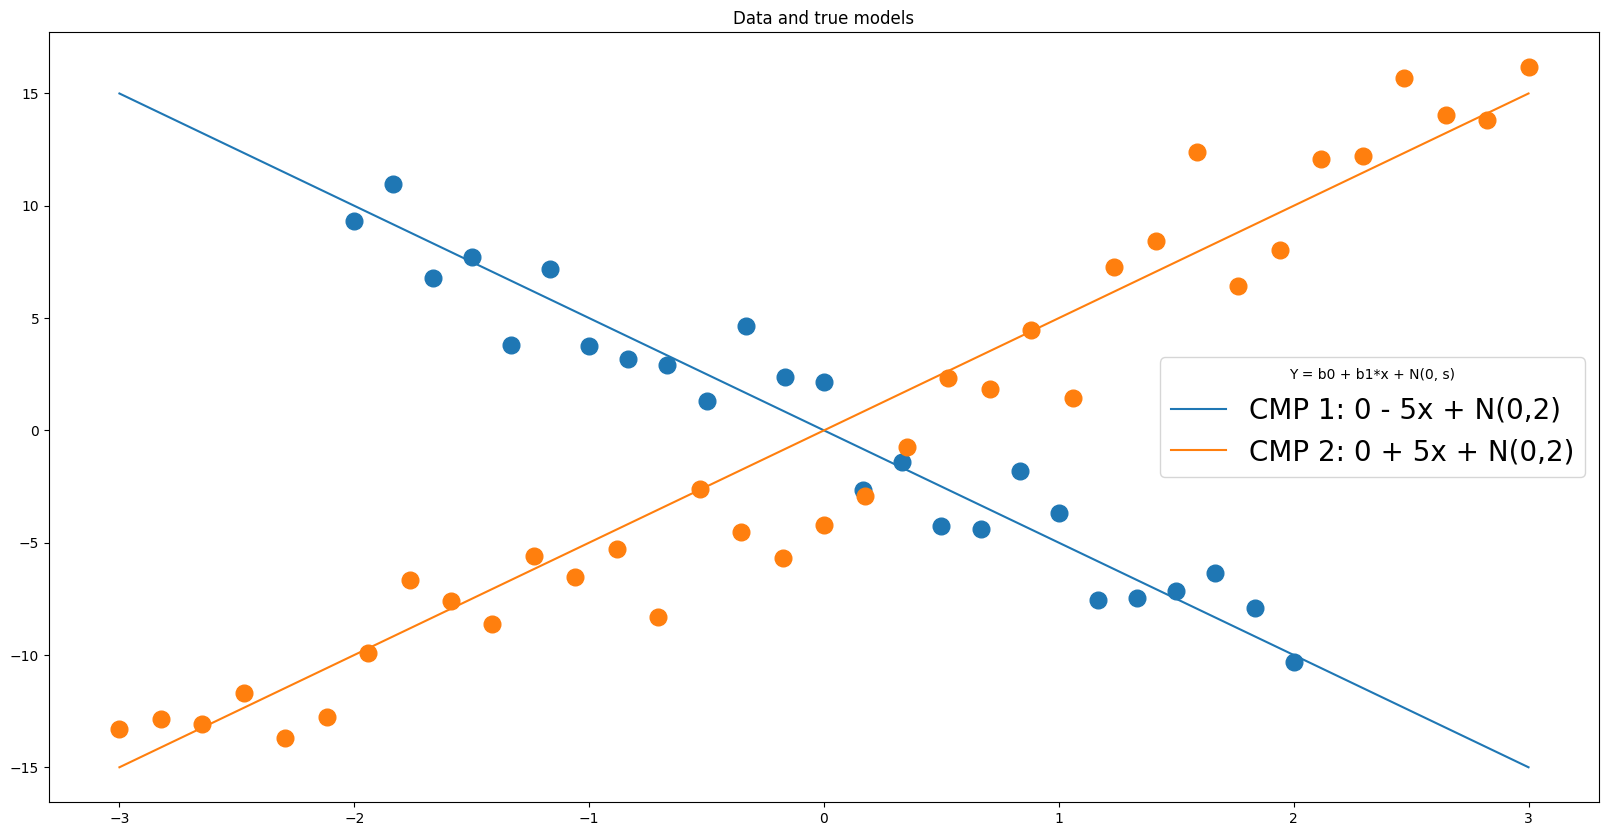

In [107]:
def sign(x):
    if x > 0: 
        return "+"
    else:
        return "-"

def plot_true_model(xs, ys, b0, b1, sigma):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    x_model = np.linspace(-3, 3)
    ax.set_title("Data and true models")

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    for x, y in zip(xs, ys):
        color = next(colors)
        ax.scatter(
            x,
            y,
            s=144,
            marker="o",
            color=color,
        )

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    for icmp, b1_ in enumerate(b1, 1):
        color = next(colors)
        y_model = b0 + b1_ * x_model
        ax.plot(
            x_model,
            y_model,
            linestyle="-",
            color=color,
            label=f"CMP {icmp}: {b0} {sign(b1_)} {np.abs(b1_)}x + N(0,{sigma})",
        )
    ax.legend(fontsize=20, title="Y = b0 + b1*x + N(0, s)")
    plt.close()
    return fig
    
fig = plot_true_model((x1, x2), (y1, y2), b0, b1, sigma)
fig


In this exercise we imagine that we do not know which component generated which data points so the plot below shows the data as seen by the clustering algorithm. Looking at the data one can easily realize that this clustering problem is difficult, especially if we do not use the only prior knowledge that that we have namely that the unknown number of components generate linear data.

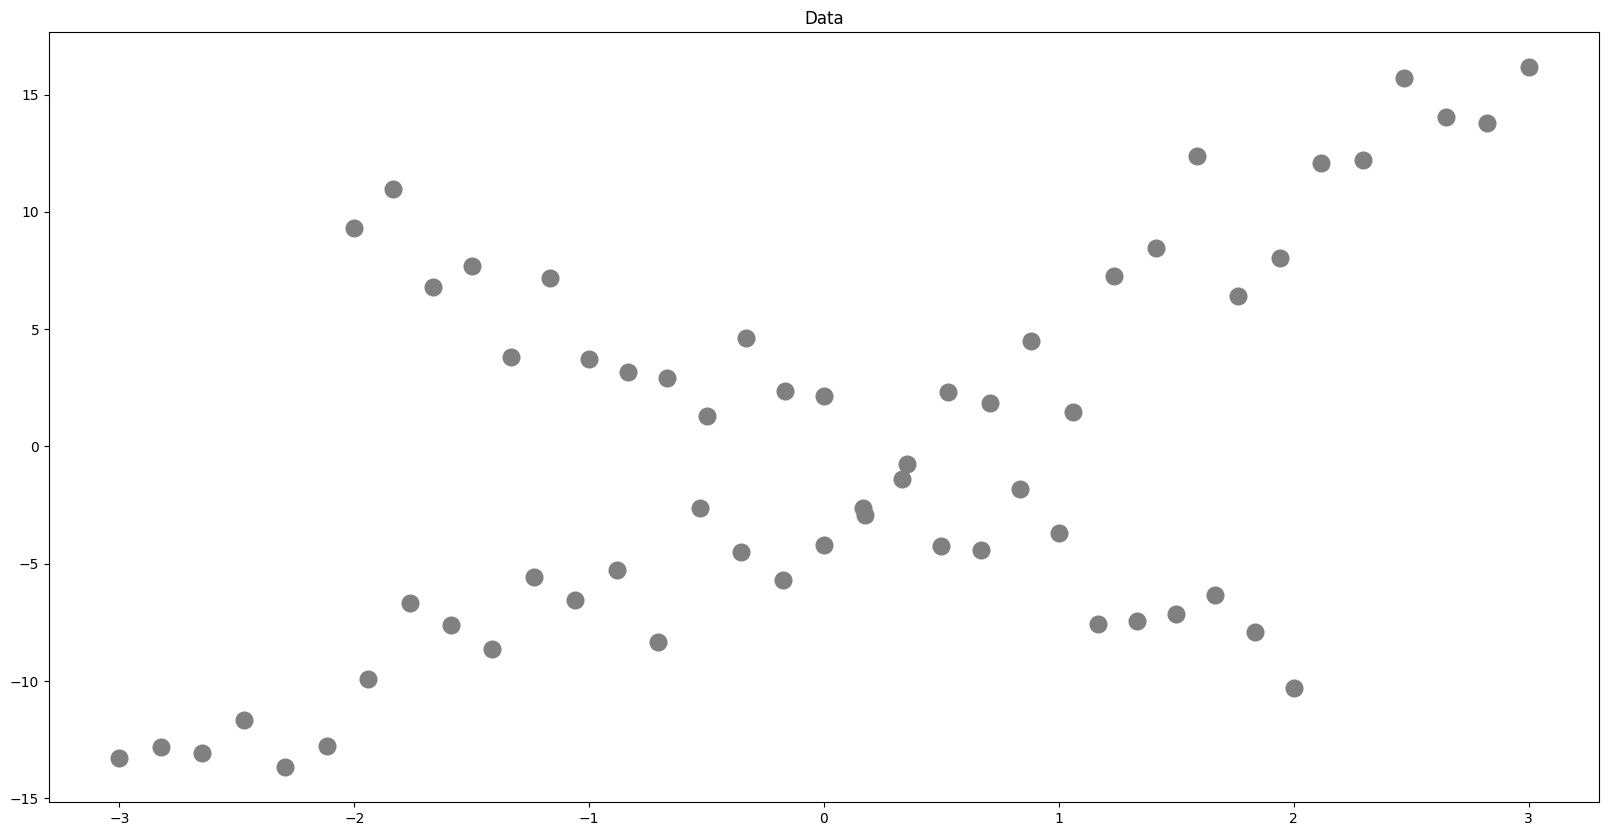

In [108]:
def plot_data(xs, ys):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.set_title("Data")
    for x, y in zip(xs, ys):
        ax.scatter(
            x,
            y,
            s=144,
            marker="o",
            color="gray",
        )
    plt.close()
    return fig

fig = plot_data((x1, x2), (y1, y2))
fig

## Curve fit - known classes

In this section I will analyze the two data sets individually using a curve fitting approach i.e. minimize the square residuals to give the maximum likelihood estimate (MLE) for the model parameters.

In [84]:
def plot_curve_fit(xs, ys):
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    for i, (x, y) in enumerate(zip(xs, ys), 1):
        popt, pcov = curve_fit(model, x, y)

        # Standard errors
        perr = np.sqrt(np.diag(pcov))

        # sigma
        sigma = np.std(model(x, *popt) - y)

        print(f"CMP {i}")
        print("popt", popt)
        print("perr", perr)
        print("pcov", np.array2string(pcov, precision=2).replace("\n", ""))
        print("sigma", sigma)
        print()

        color = next(colors)

        sns.regplot(
            x=x,
            y=y,
            ci=95,
            order=1,
            line_kws={
                "label": f"CMP{i}. MLE={popt} (σ={sigma})",
                "color": color,
            },
            scatter_kws={
                "s": 144,
            },
            seed=1,
            label=f"CMP{i} data.",
            truncate=False,
            color=color,
            ax=axs[0],
        )

        plot_parameters(popt, pcov, axs[1], f"CMP{i}", nstds=[2], color=color)

    axs[0].set_xlabel("x", fontsize=NORMAL_FONTSIZE)
    axs[0].set_ylabel("y", fontsize=NORMAL_FONTSIZE)
    axs[0].legend(fontsize=20)

    axs[1].legend(fontsize=20)
    axs[1].set_xlabel("b0", fontsize=NORMAL_FONTSIZE)
    axs[1].set_ylabel("b1", fontsize=NORMAL_FONTSIZE)

    for ax in axs.flat:
        ax.tick_params(axis="both", which="major", labelsize=NORMAL_FONTSIZE)

    fig.suptitle("MLE parameters inferred from true classes")
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.close()
    return fig


Here's the MLEs for the two components.

In [109]:
fig = plot_curve_fit((x1, x2), (y1, y2))

CMP 1
popt [ 0.0468254  -4.77473983]
perr [0.31791169 0.26451845]
pcov [[ 1.01e-01 -1.71e-09] [-1.71e-09  7.00e-02]]
sigma 1.5246505366916425

CMP 2
popt [-0.56841699  5.15816947]
perr [0.38126721 0.21392277]
pcov [[1.45e-01 1.06e-09] [1.06e-09 4.58e-02]]
sigma 2.190213287009664



In the first figure below I have shown the data, the MLE for the parameters as well as the confidence interval (uncertainty of the mean outcome). In the second plot the parameter covariance matrix is illustrated and shows us that $b_0$ and $b_1$ essentially have zero correlation.

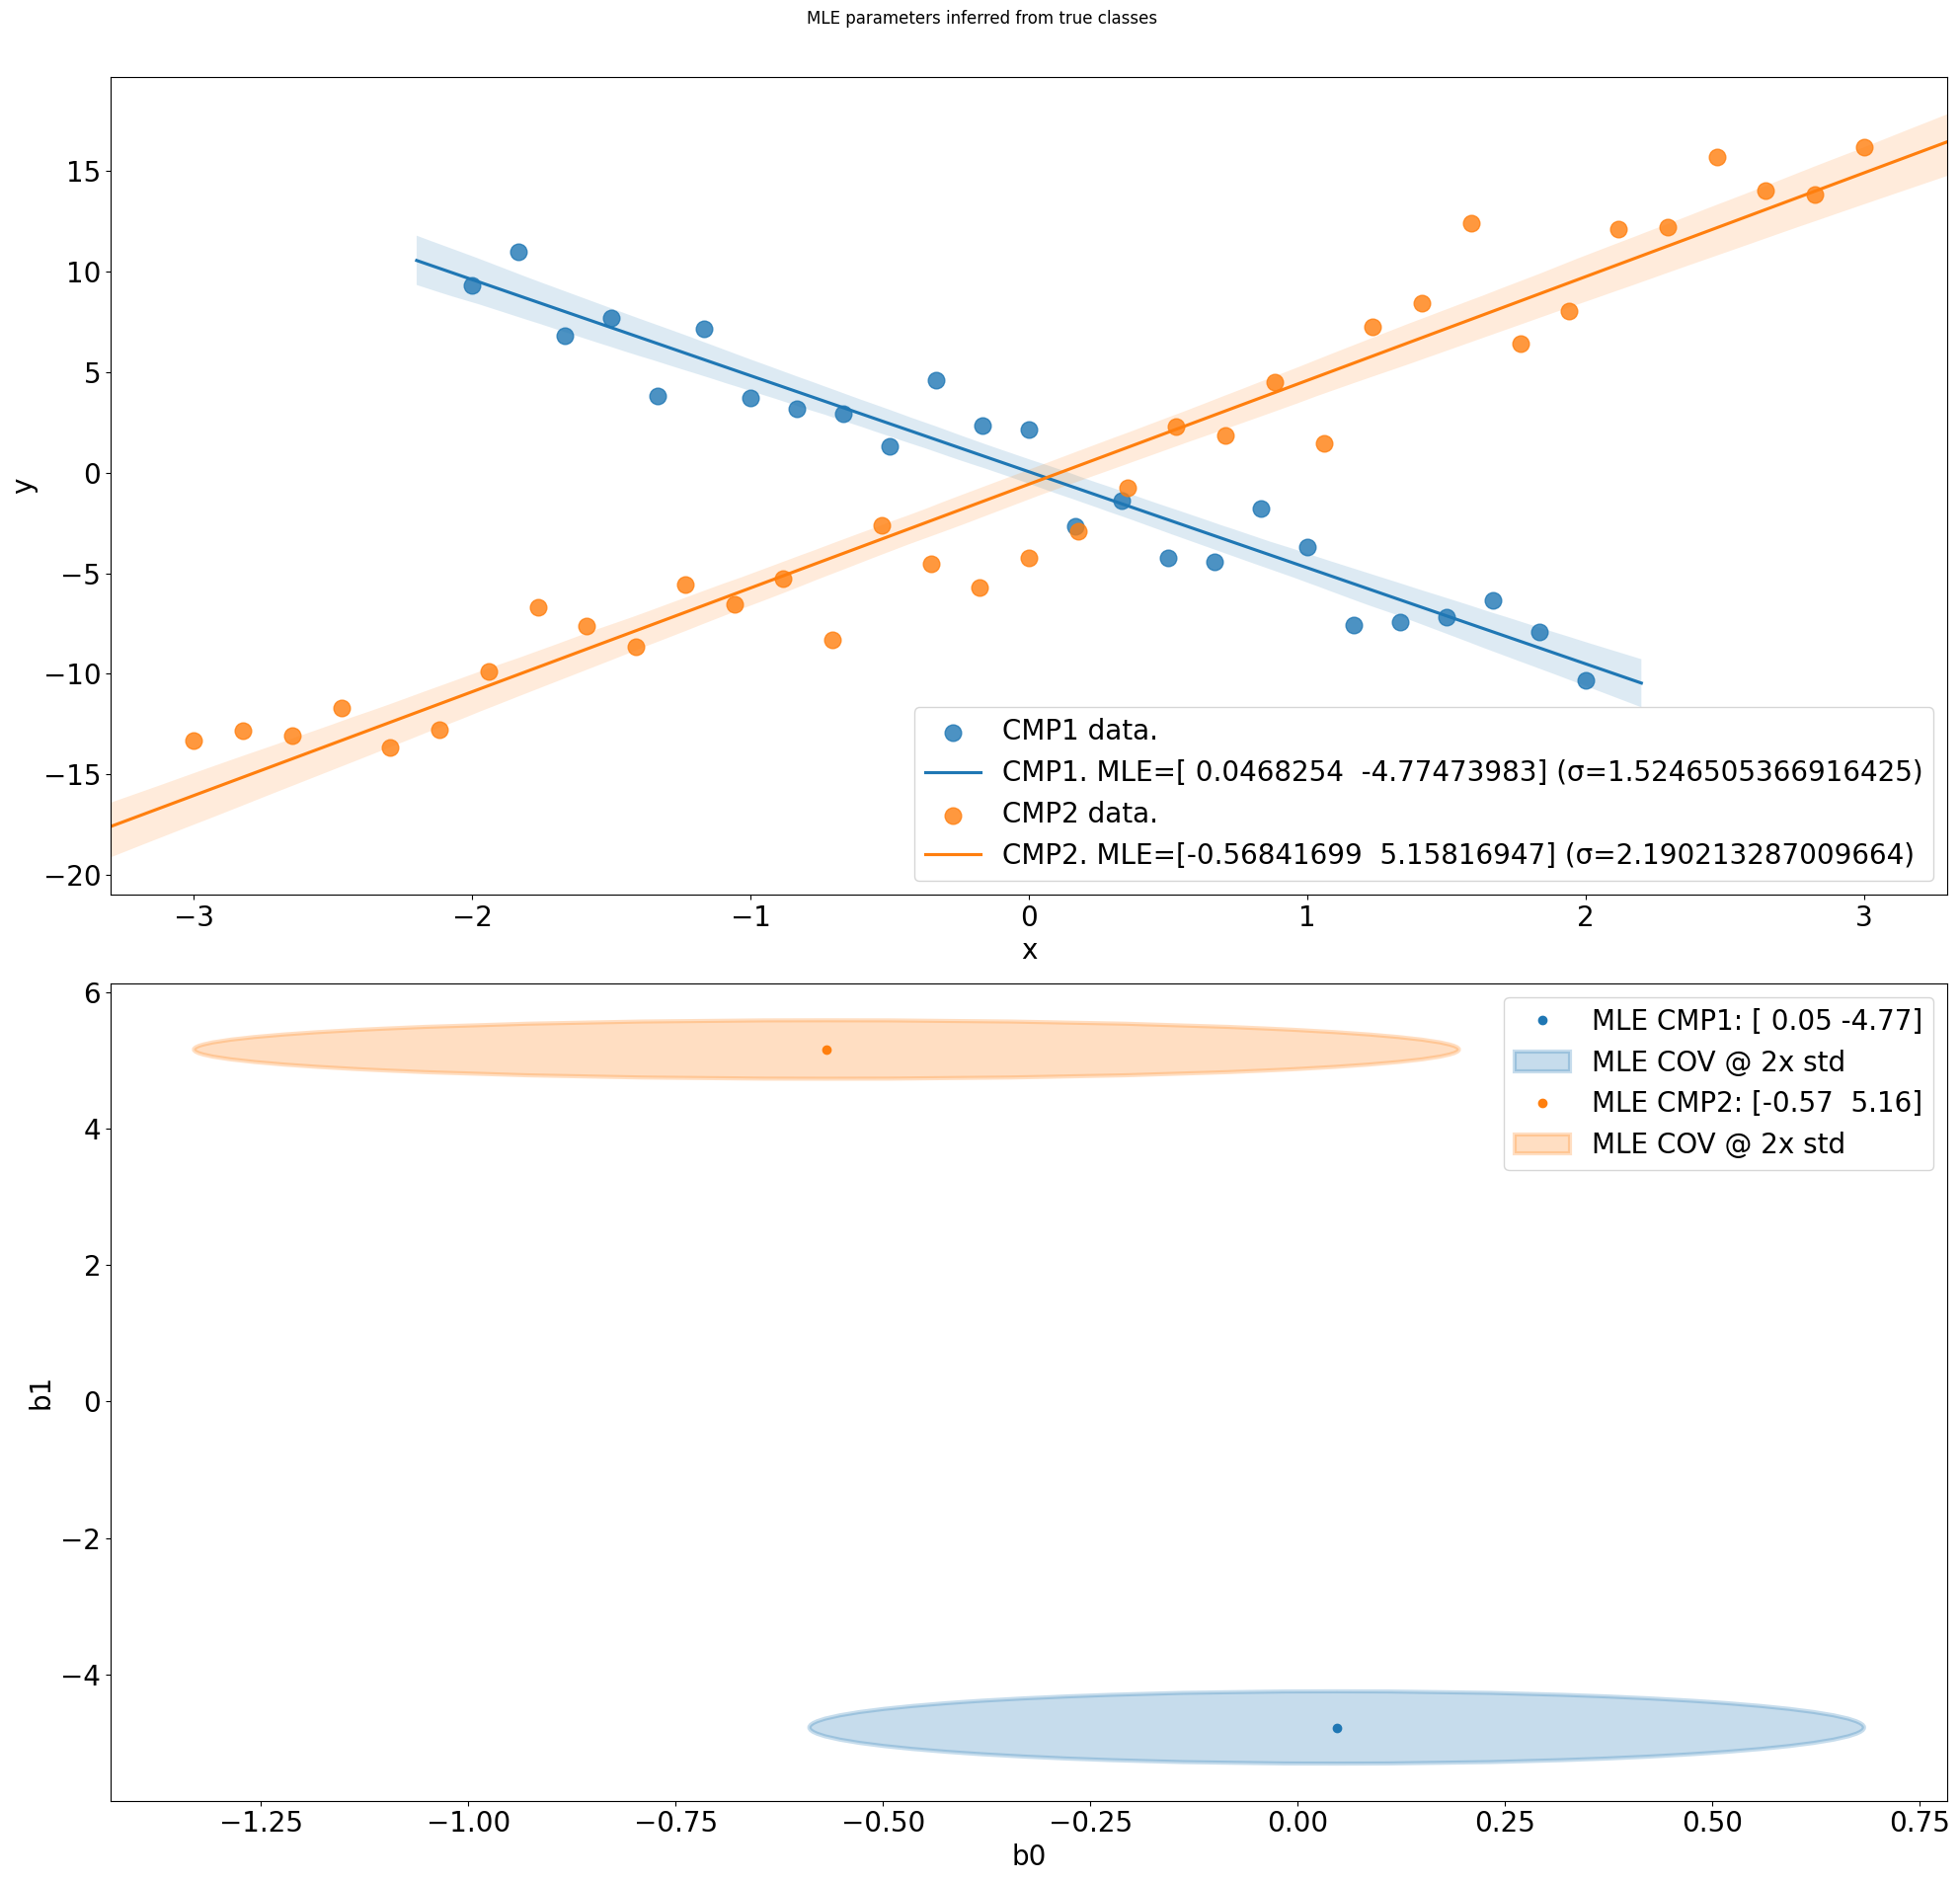

In [110]:
fig

## Bayesian inference - known classes

Since we will be using a Bayesian model to solve the problem at hand, namely find a regression mixture model, I will briefly go through a Bayesian inference that is more or less equivalent to the curve fitting approach. Below I define a linear model explicitly showing how the model is composed and create the posterior parameter distribution by sampling. 

In [116]:
def fit_c1(x, y, return_inferencedata: bool = False, nsteps: int = 10000, nchains: int = 4):
    """One-component "mixture" """
    model = pm.Model()
    with model:
        b0 = pm.Normal("b0", 0, sigma=20)
        b1 = pm.Normal("b1", 0, sigma=20)
        y_est = b0 + b1 * x
        sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
        likelihood = pm.Normal("y", mu=y_est, sigma=sigma, observed=y)

        trace = pm.sample(
            nsteps, return_inferencedata=return_inferencedata, chains=nchains
        )
        return trace, model


With this model I execute the sampling and create some plots that summarize the posterior parameter distribution in various ways.

In [117]:
def plot_bayesian_fit(xs, ys, nsteps=25000, do_ppc: bool = True):
    # Bayesian inference for the true classes
    point_estimate = "mean"
    var_names = ["b0", "b1", "sigma"]
    var_names_pairs = ["b0", "b1"]

    fig_posterior, axs = plt.subplots(len(xs), len(var_names), figsize=(20, 20))
    fig_pair, axs_pair = plt.subplots(len(xs), 1, figsize=(20, 20))

    hdi_prob = az.rcParams["stats.hdi_prob"]

    if do_ppc is not None:
        fig_gppc, axs_gppc = plt.subplots(len(xs), 1, figsize=(20, 20))
        fig_mppc, axs_mppc = plt.subplots(len(xs), 1, figsize=(20, 20))
    else:
        fig_gppc = None
        fig_mppc = None

    for i, (x, y) in enumerate(zip(xs, ys)):

        trace, model = fit_c1(
            x,
            y,
            nsteps=nsteps,
            return_inferencedata=True,
        )

        az.plot_posterior(
            trace,
            var_names=var_names,
            point_estimate=point_estimate,
            ax=axs[i, :],
        )
        plt.close()


        az.plot_pair(
            trace,
            var_names=var_names_pairs,
            kind="kde",
            point_estimate="mean",
            divergences=True,
            textsize=18,
            ax=axs_pair[i],
        )
        plt.close()


        if do_ppc:
            with model:
                ppc = pm.sample_posterior_predictive(
                    trace, var_names=["b0", "b1", "y"], random_seed=RANDOM_SEED
                )

            # az.plot_ppc(
            #     az.from_pymc3(posterior_predictive=ppc, model=model), ax=axs_gppc[i]
            # )

            mu_pp = (ppc["b0"] + ppc["b1"] * x[:, None]).T
            axs_mppc[i].plot(x, y, "o", ms=4, alpha=0.4, label="Data")
            axs_mppc[i].plot(x, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
            az.plot_hdi(
                x,
                mu_pp,
                ax=axs_mppc[i],
                fill_kwargs={"alpha": 0.8, "label": f"Mean outcome {hdi_prob*100} % HDI"},
            )
            plt.close()

            az.plot_hdi(
                x,
                ppc["y"],
                ax=axs_mppc[i],
                fill_kwargs={
                    "alpha": 0.8,
                    "color": "#a1dab4",
                    "label": f"Outcome {hdi_prob}*100 % HDI",
                },
            )
            plt.close()

            axs_mppc[i].set_xlabel("Predictor")
            axs_mppc[i].set_ylabel("Outcome")
            axs_mppc[i].set_title("Posterior predictive checks")
            axs_mppc[i].legend(ncol=2, fontsize=12)

    return fig_posterior, fig_pair, fig_gppc, fig_mppc


Run analysis

In [118]:
do_ppc = True
fig_posterior, fig_pair, fig_gppc, fig_mppc = plot_bayesian_fit(
    (x1, x2),
    (y1, y2),
    nsteps=10000,
    do_ppc=do_ppc,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b1, b0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 11 seconds.


/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b1, b0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.


/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Below the marginal distributions of `b0` (intercept), `b1` (slope) and `sigma` (random error) are shown along with a point estimate for the mean and the 94 % high density interval (HDI). These estimates are quite close to the results obtained from the curve fit.

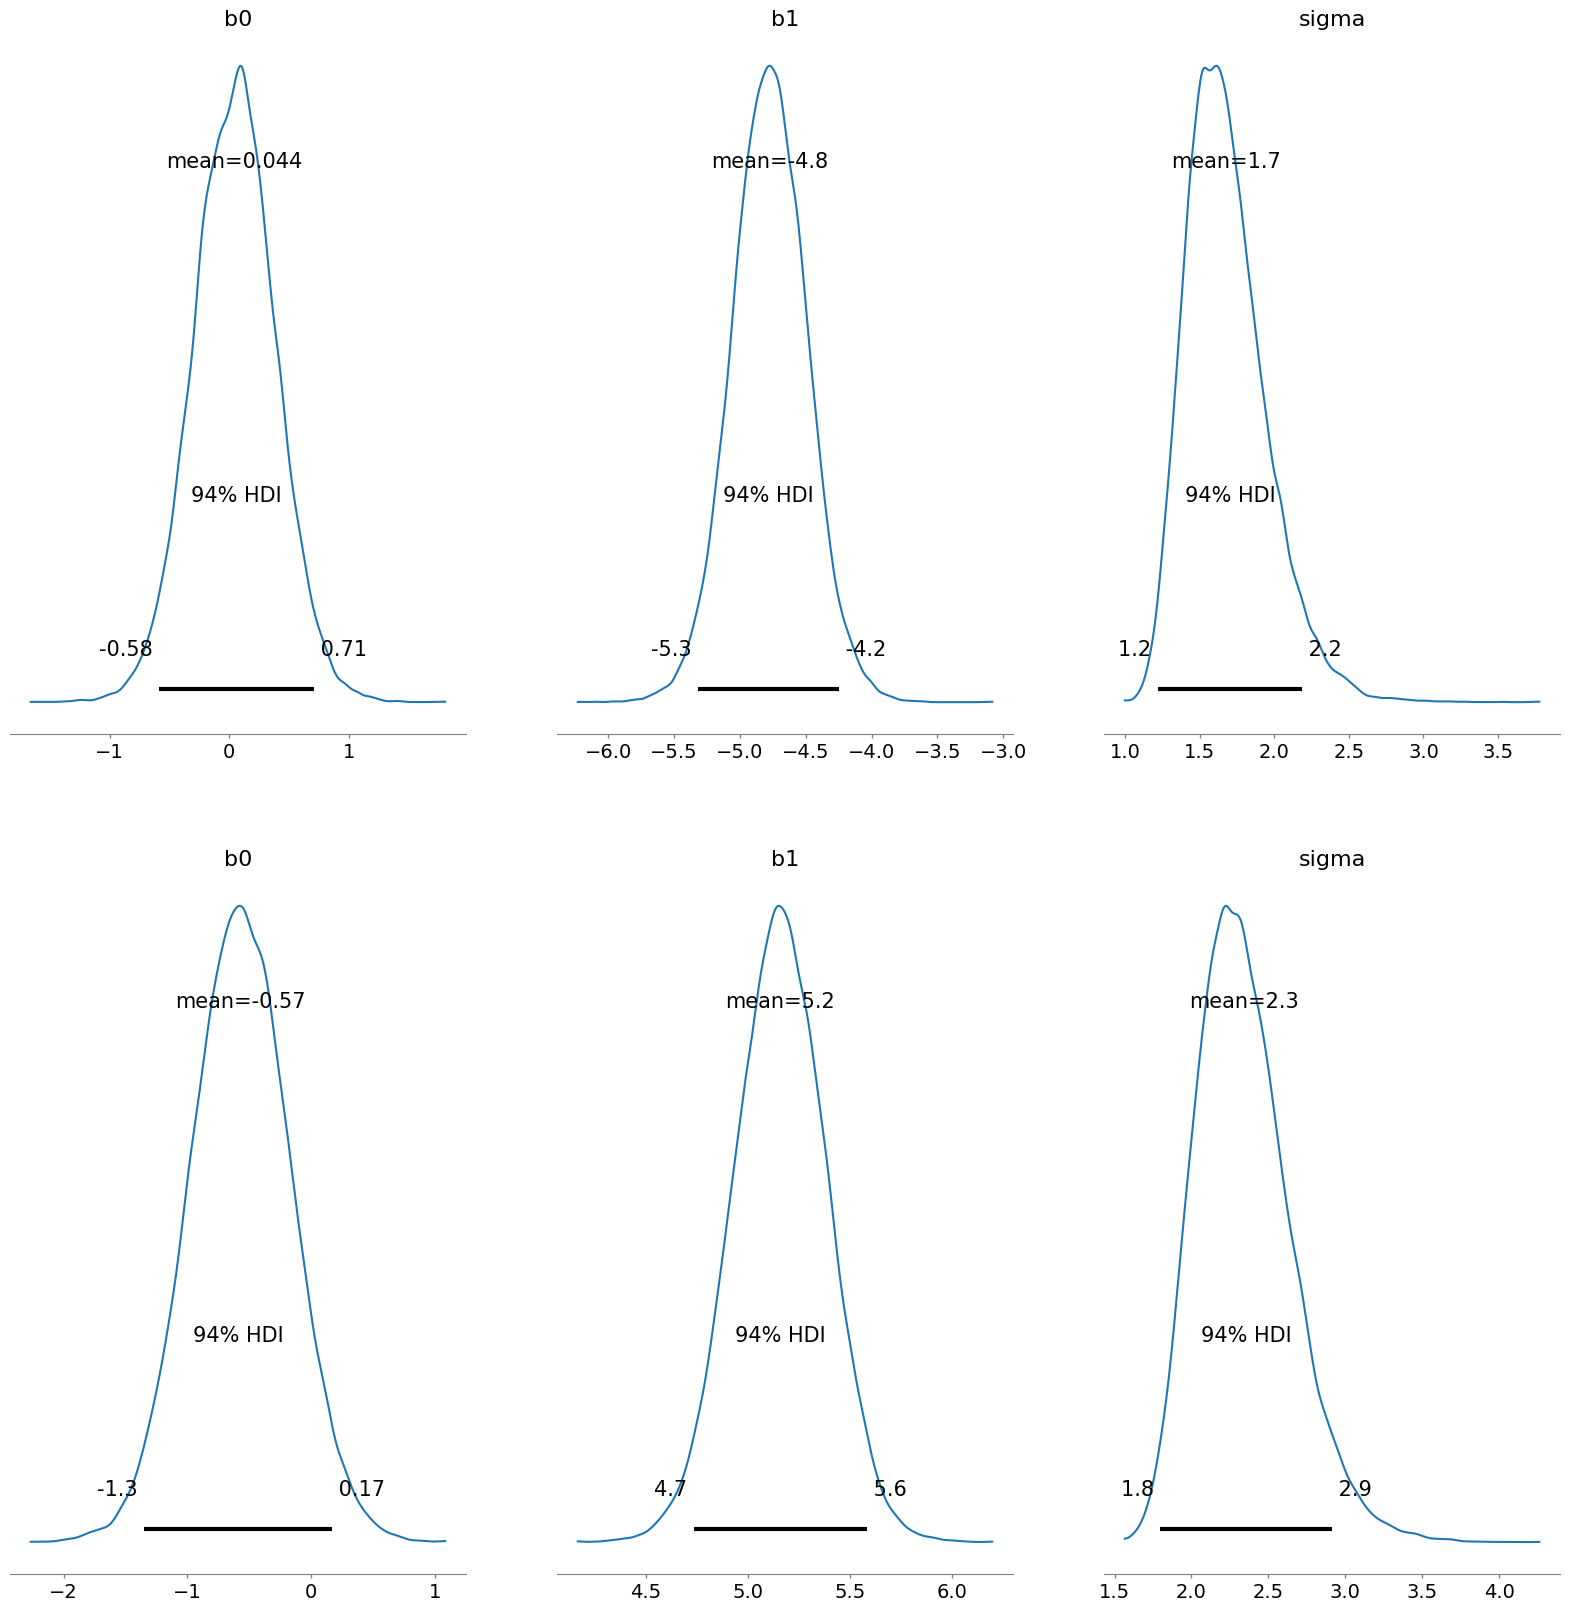

In [119]:
fig_posterior

As for the curve fit we can illustrate how `b0` and `b1` covary for the two components. The black point mark the mean.

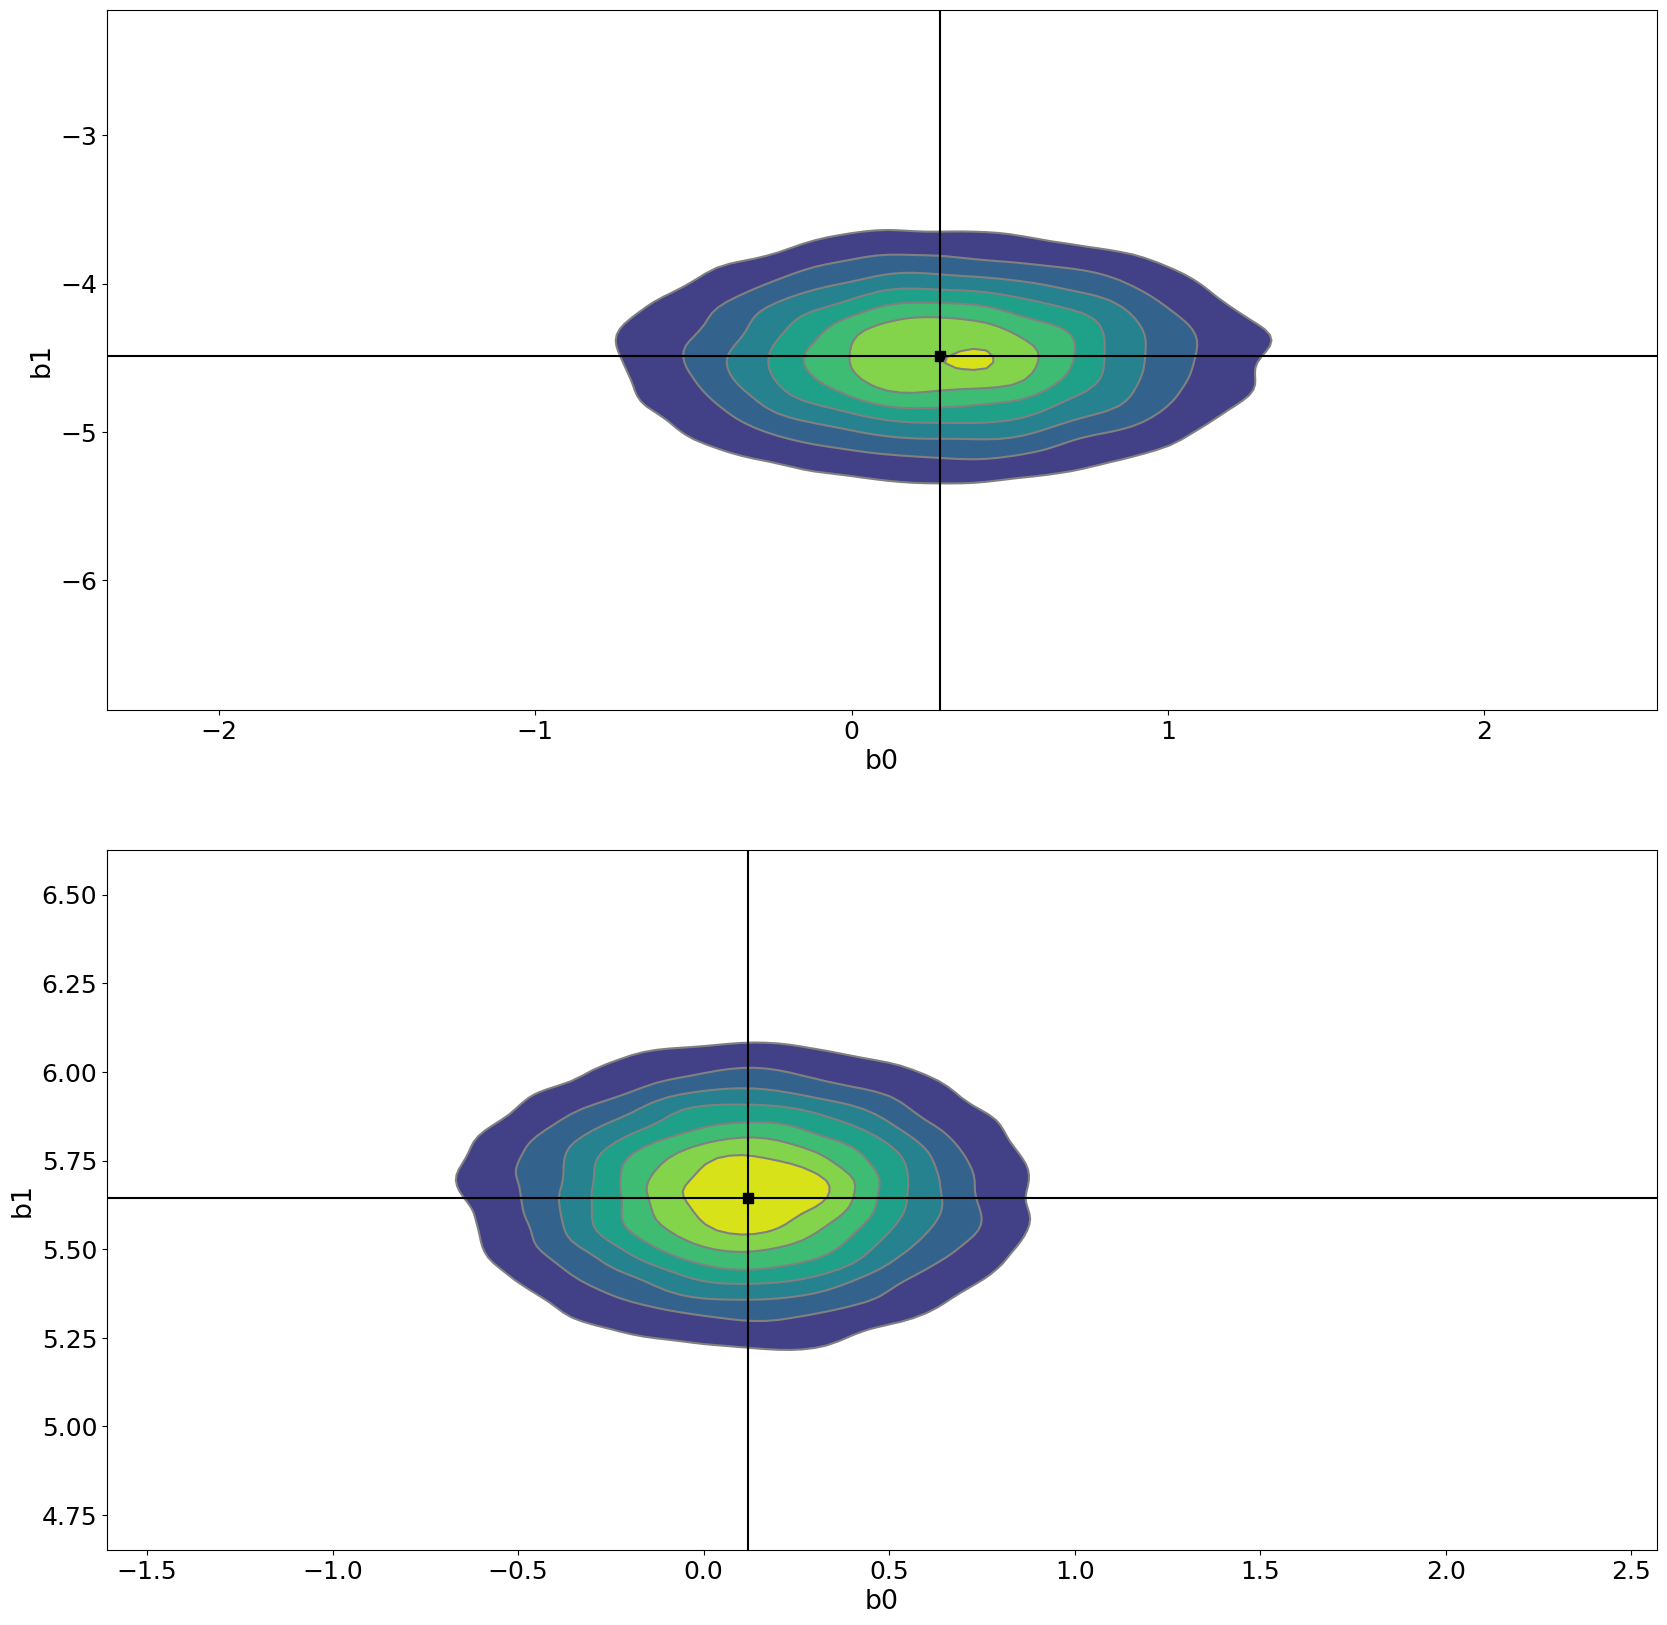

In [82]:
fig_pair

The plot below illustrates how samples from the posterior parameter distribution propagate through the model to give a distribution of outcomes. These outcomes are summarized as high density intervals for the mean outcome and the outcome. The data is also included to verify that the parameter estimates are reasonable.

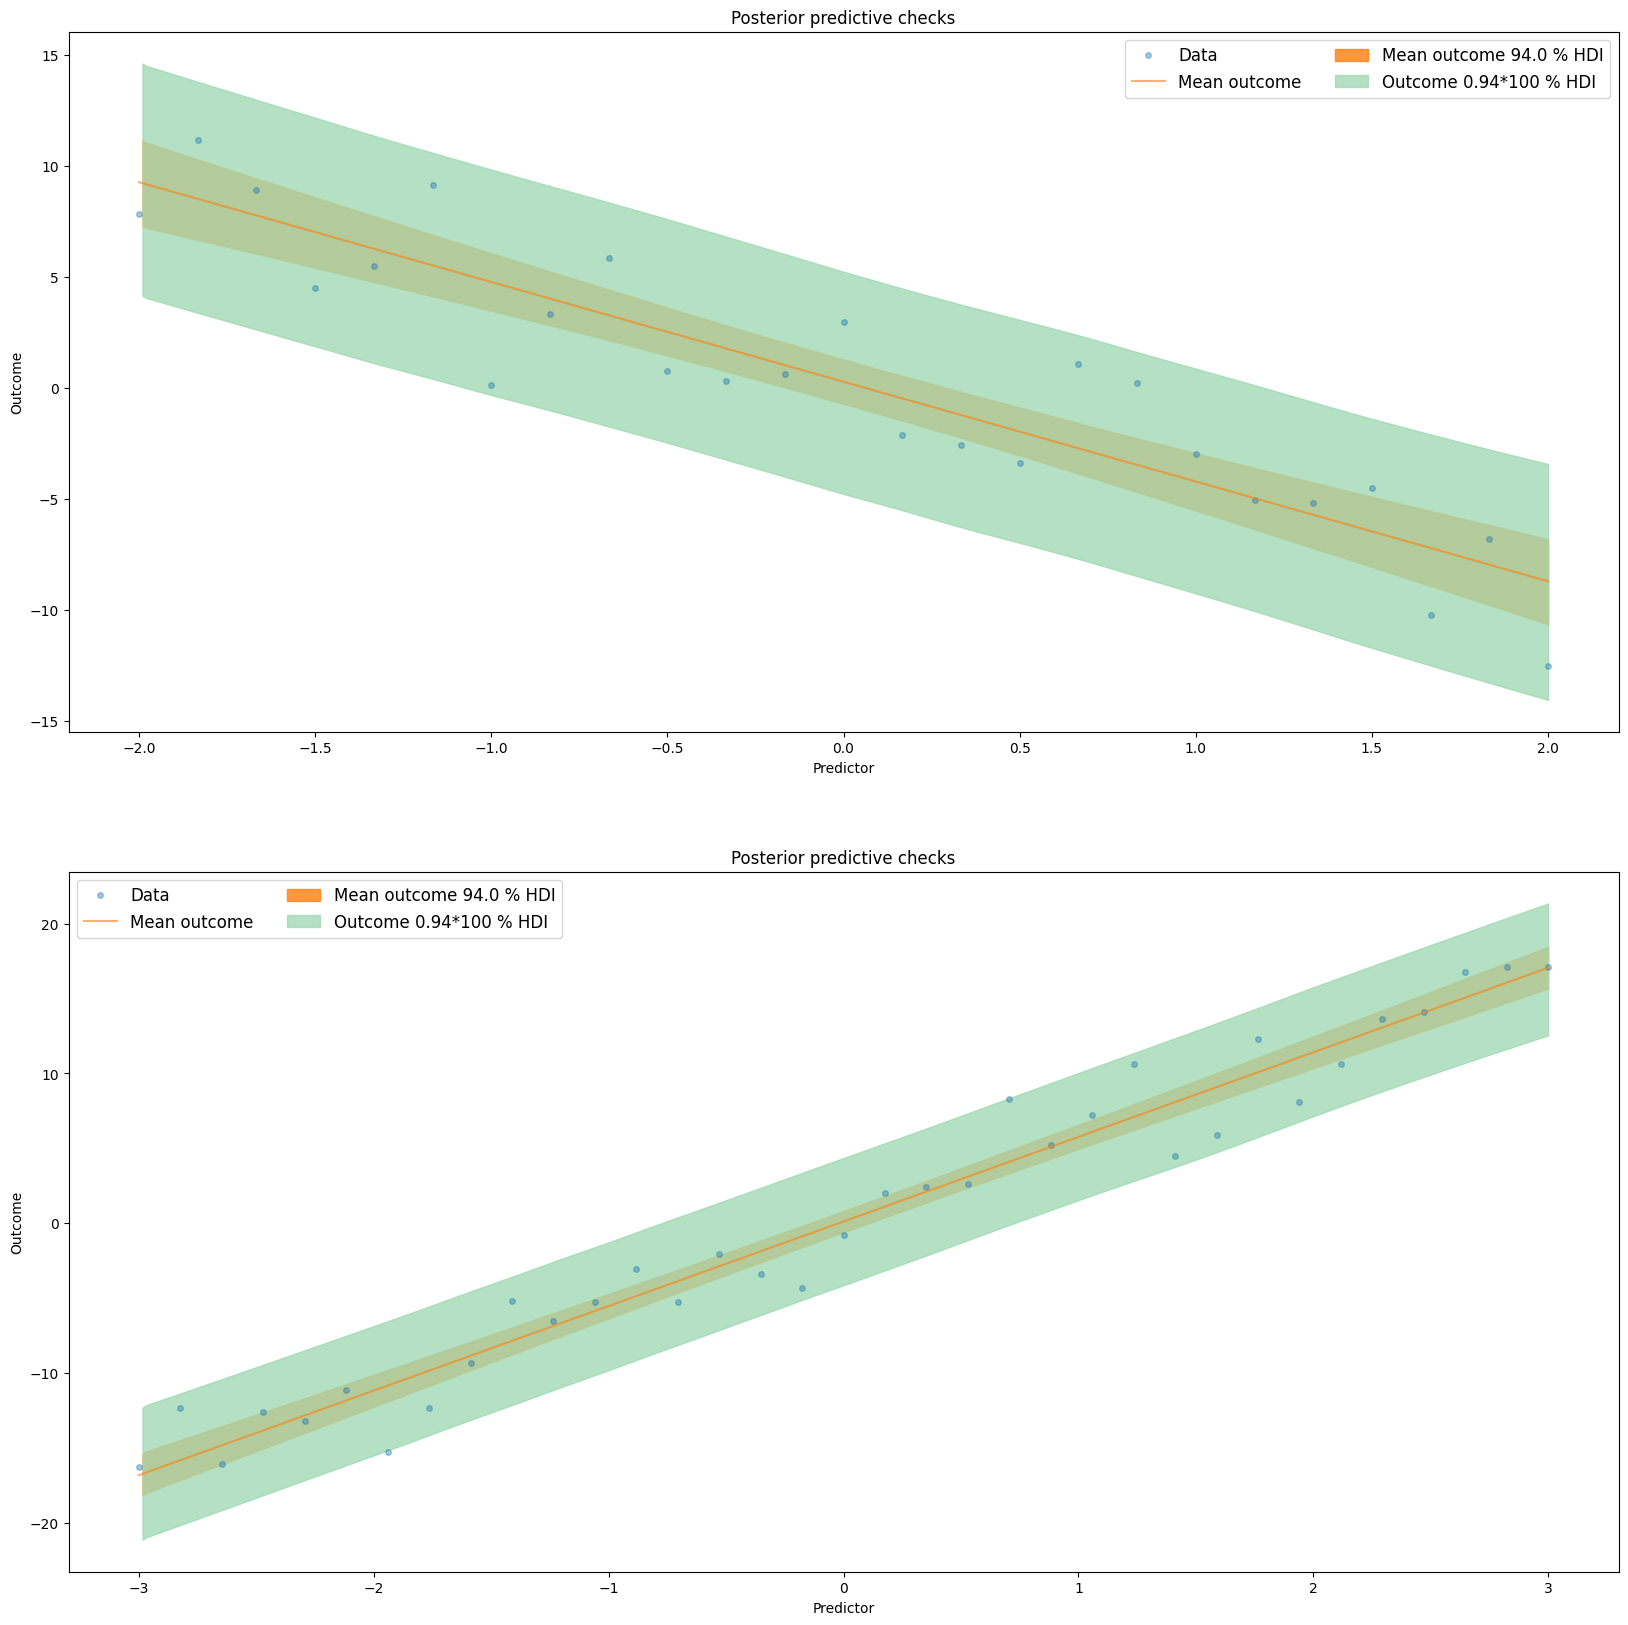

In [83]:
fig_mppc

In [ ]:
%watermark  -n -u -v -iv -w